In [1]:
import os
import time
import pickle
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from google.colab import files

In [2]:
!pip install kaggle --quiet

print("Veuillez uploader votre fichier kaggle.json")
uploaded = files.upload()

if 'kaggle.json' in uploaded:
    print("\nFichier kaggle.json uploadé avec succès.")
    if not os.path.exists('/root/.kaggle'):
        os.makedirs('/root/.kaggle')
    os.rename('kaggle.json', '/root/.kaggle/kaggle.json')
    os.chmod('/root/.kaggle/kaggle.json', 600)

    print("Téléchargement du jeu de données AMHCD...")
    !kaggle datasets download -d benaddym/amazigh-handwritten-character-database-amhcd -p /content/data --unzip --quiet
    print("Jeu de données téléchargé et décompressé dans /content/data/")

else:
    print("\n Erreur : Le fichier kaggle.json n'a pas été trouvé.")

print("\nContenu du dossier de données :")
!ls /content/data

Veuillez uploader votre fichier kaggle.json


Saving kaggle.json to kaggle.json

Fichier kaggle.json uploadé avec succès.
Téléchargement du jeu de données AMHCD...
Dataset URL: https://www.kaggle.com/datasets/benaddym/amazigh-handwritten-character-database-amhcd
License(s): other
Jeu de données téléchargé et décompressé dans /content/data/

Contenu du dossier de données :
amhcd_64  AMHCD_64  labels


In [3]:
def load_data_from_folders(root_path):

    print(f"\nDébut du chargement des images depuis : {root_path}")
    images = []
    labels_int = []

    class_names = sorted([d for d in os.listdir(root_path) if os.path.isdir(os.path.join(root_path, d))])
    if not class_names:
        raise ValueError(f"ERREUR : Aucun dossier de classe trouvé dans '{root_path}'.")

    label_to_int = {name: i for i, name in enumerate(class_names)}
    print(f"{len(class_names)} classes trouvées.")

    for class_name in class_names:
        class_path = os.path.join(root_path, class_name)
        for image_file in os.listdir(class_path):
            if image_file.endswith('.jpeg'):
                img_path = os.path.join(class_path, image_file)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    img_resized = cv2.resize(img, (32, 32))
                    images.append(img_resized)
                    labels_int.append(label_to_int[class_name])

    images = np.array(images, dtype='float32') / 255.0
    labels_int = np.array(labels_int)

    images = np.expand_dims(images, axis=1)

    print(f"Total de {len(images)} images chargées.")

    x_train, x_test, y_train_int, y_test_labels = train_test_split(
        images, labels_int, test_size=0.20, random_state=42, stratify=labels_int
    )

    num_classes = len(class_names)
    y_train = np.eye(num_classes)[y_train_int]
    y_test = np.eye(num_classes)[y_test_labels]

    return x_train, y_train, x_test, y_test, y_test_labels, class_names

try:
    data_root_folder = '/content/data/AMHCD_64/AMHCD_64/'
    x_train, y_train, x_test, y_test, y_test_labels, class_names = load_data_from_folders(root_path=data_root_folder)

    print("\n--- Préparation des données terminée ---")
    print(f"Format des données d'entraînement (images):\t{x_train.shape}")
    print(f"Format des données d'entraînement (labels):\t{y_train.shape}")
    print(f"Format des données de test (images):\t\t{x_test.shape}")
    print(f"Format des données de test (labels):\t\t{y_test.shape}")
    print(f"Nombre de classes détectées:\t\t{len(class_names)}")
except Exception as e:
    print(f"\n Une erreur est survenue : {e}")


Début du chargement des images depuis : /content/data/AMHCD_64/AMHCD_64/
33 classes trouvées.
Total de 25740 images chargées.

--- Préparation des données terminée ---
Format des données d'entraînement (images):	(20592, 1, 32, 32)
Format des données d'entraînement (labels):	(20592, 33)
Format des données de test (images):		(5148, 1, 32, 32)
Format des données de test (labels):		(5148, 33)
Nombre de classes détectées:		33


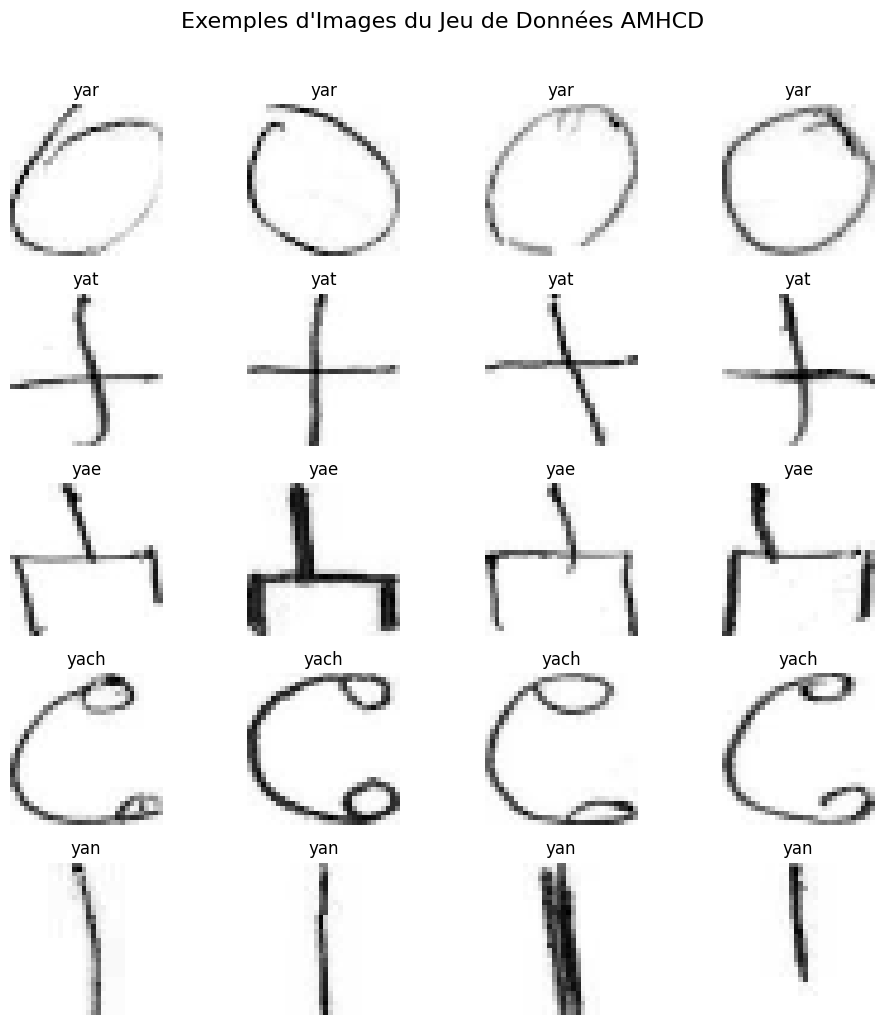

In [4]:
def display_sample_images(images, labels_onehot, class_names, num_classes_to_show=5, num_examples=4):

    plt.style.use('default')
    fig, axes = plt.subplots(num_classes_to_show, num_examples, figsize=(10, 10))
    fig.suptitle("Exemples d'Images du Jeu de Données AMHCD", fontsize=16, y=1.02)

    labels_int = np.argmax(labels_onehot, axis=1)

    unique_class_indices = np.unique(labels_int)
    selected_class_indices = np.random.choice(unique_class_indices, num_classes_to_show, replace=False)

    for i, class_idx in enumerate(selected_class_indices):
        indices_for_class = np.where(labels_int == class_idx)[0]
        sample_indices = np.random.choice(indices_for_class, num_examples, replace=False)
        for j, image_idx in enumerate(sample_indices):
            image = images[image_idx].squeeze()
            ax = axes[i, j]
            ax.imshow(image, cmap='gray')
            ax.set_title(class_names[class_idx])
            ax.axis('off')

    plt.tight_layout()
    plt.show()

display_sample_images(x_train, y_train, class_names, num_classes_to_show=5, num_examples=4)

In [5]:
class Tanh:
    def forward(self, x):
        self.y = np.tanh(x)
        return self.y
    def backward(self, grad):
        return grad * (1 - self.y**2)

class Softmax:
    def forward(self, x):
        exps = np.exp(x - np.max(x, axis=-1, keepdims=True))
        self.y = exps / np.sum(exps, axis=-1, keepdims=True)
        return self.y
    def backward(self, grad):
        return grad

class Conv2D:
    def __init__(self, in_channels, out_channels, kernel_size=5, stride=1):
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.weights = np.random.randn(out_channels, in_channels, kernel_size, kernel_size) * np.sqrt(2. / (in_channels * kernel_size**2))
        self.biases = np.zeros((1, out_channels, 1, 1))

    def forward(self, x):
        self.x = x
        n, _, h_in, w_in = x.shape
        h_out = (h_in - self.kernel_size) // self.stride + 1
        w_out = (w_in - self.kernel_size) // self.stride + 1
        self.out = np.zeros((n, self.out_channels, h_out, w_out))
        for i in range(h_out):
            for j in range(w_out):
                h_start, w_start = i * self.stride, j * self.stride
                h_end, w_end = h_start + self.kernel_size, w_start + self.kernel_size
                patch = x[:, :, h_start:h_end, w_start:w_end]
                for k in range(self.out_channels):
                    self.out[:, k, i, j] = np.sum(patch * self.weights[k, ...], axis=(1, 2, 3))
        return self.out + self.biases

    def backward(self, grad_out):
        self.grad_weights = np.zeros_like(self.weights)
        self.grad_biases = np.sum(grad_out, axis=(0, 2, 3)).reshape(self.biases.shape)
        grad_x = np.zeros_like(self.x)
        _, _, h_out, w_out = grad_out.shape
        for i in range(h_out):
            for j in range(w_out):
                h_start, w_start = i * self.stride, j * self.stride
                h_end, w_end = h_start + self.kernel_size, w_start + self.kernel_size
                for k in range(self.out_channels):
                    self.grad_weights[k, ...] += np.sum(self.x[:, :, h_start:h_end, w_start:w_end] * grad_out[:, k, i, j][:, np.newaxis, np.newaxis, np.newaxis], axis=0)
                for n in range(self.x.shape[0]):
                    grad_x[n, :, h_start:h_end, w_start:w_end] += np.sum(self.weights * grad_out[n, :, i, j][:, np.newaxis, np.newaxis, np.newaxis], axis=0)
        return grad_x

class AvgPool2D:
    def __init__(self, kernel_size=2, stride=2):
        self.kernel_size = kernel_size
        self.stride = stride

    def forward(self, x):
        self.x = x
        n, c, h_in, w_in = x.shape
        h_out = h_in // self.stride
        w_out = w_in // self.stride
        out = np.zeros((n, c, h_out, w_out))
        for i in range(h_out):
            for j in range(w_out):
                h_start, w_start = i * self.stride, j * self.stride
                h_end, w_end = h_start + self.kernel_size, w_start + self.kernel_size
                patch = x[:, :, h_start:h_end, w_start:w_end]
                out[:, :, i, j] = np.mean(patch, axis=(2, 3))
        return out

    def backward(self, grad_out):
        grad_x = np.zeros_like(self.x)
        _, _, h_out, w_out = grad_out.shape
        for i in range(h_out):
            for j in range(w_out):
                h_start, w_start = i * self.stride, j * self.stride
                h_end, w_end = h_start + self.kernel_size, w_start + self.kernel_size
                grad_val = grad_out[:, :, i, j][:, :, np.newaxis, np.newaxis]
                grad_x[:, :, h_start:h_end, w_start:w_end] += grad_val / (self.kernel_size * self.kernel_size)
        return grad_x

class Flatten:
    def forward(self, x):
        self.x_shape = x.shape
        return x.reshape(x.shape[0], -1)
    def backward(self, grad):
        return grad.reshape(self.x_shape)

class Dense:
    def __init__(self, in_features, out_features):
        self.weights = np.random.randn(in_features, out_features) * np.sqrt(2.0 / in_features)
        self.biases = np.zeros(out_features)

    def forward(self, x):
        self.x = x
        return x @ self.weights + self.biases

    def backward(self, grad_out):
        self.grad_weights = self.x.T @ grad_out
        self.grad_biases = np.sum(grad_out, axis=0)
        return grad_out @ self.weights.T

In [6]:
class LeNet5_Tifinagh:
    def __init__(self, num_classes=33):
        self.c1 = Conv2D(in_channels=1, out_channels=6, kernel_size=5)
        self.tanh1 = Tanh()
        self.s2 = AvgPool2D(kernel_size=2, stride=2)
        self.tanh2 = Tanh()
        self.c3 = Conv2D(in_channels=6, out_channels=16, kernel_size=5)
        self.tanh3 = Tanh()
        self.s4 = AvgPool2D(kernel_size=2, stride=2)
        self.tanh4 = Tanh()
        self.flatten = Flatten()
        self.c5 = Dense(in_features=16*5*5, out_features=120)
        self.tanh5 = Tanh()
        self.f6 = Dense(in_features=120, out_features=84)
        self.tanh6 = Tanh()
        self.output = Dense(in_features=84, out_features=num_classes)
        self.softmax = Softmax()

        self.layers_with_params = [self.c1, self.c3, self.c5, self.f6, self.output]

    def forward(self, x):
        out = self.c1.forward(x)
        self.feature_maps_c1 = out
        out = self.tanh1.forward(out)
        out = self.s2.forward(out)
        out = self.tanh2.forward(out)
        out = self.c3.forward(out)
        self.feature_maps_c3 = out
        out = self.tanh3.forward(out)
        out = self.s4.forward(out)
        out = self.tanh4.forward(out)
        out = self.flatten.forward(out)
        out = self.c5.forward(out)
        out = self.tanh5.forward(out)
        out = self.f6.forward(out)
        out = self.tanh6.forward(out)
        out = self.output.forward(out)
        out = self.softmax.forward(out)
        return out

    def backward(self, grad):
        grad = self.softmax.backward(grad)
        grad = self.output.backward(grad)
        grad = self.tanh6.backward(grad)
        grad = self.f6.backward(grad)
        grad = self.tanh5.backward(grad)
        grad = self.c5.backward(grad)
        grad = self.flatten.backward(grad)
        grad = self.tanh4.backward(grad)
        grad = self.s4.backward(grad)
        grad = self.tanh3.backward(grad)
        grad = self.c3.backward(grad)
        grad = self.tanh2.backward(grad)
        grad = self.s2.backward(grad)
        grad = self.tanh1.backward(grad)
        grad = self.c1.backward(grad)

In [7]:
def categorical_cross_entropy(y_pred, y_true):
    y_pred = np.clip(y_pred, 1e-12, 1. - 1e-12)
    loss = -np.sum(y_true * np.log(y_pred)) / y_pred.shape[0]
    grad = (y_pred - y_true) / y_pred.shape[0]
    return loss, grad

class SGD:
    def __init__(self, learning_rate=0.1):
        self.lr = learning_rate

    def update(self, layers):
        for layer in layers:
            if hasattr(layer, 'weights'):
                layer.weights -= self.lr * layer.grad_weights
                layer.biases -= self.lr * layer.grad_biases

def train(model, x_train, y_train, x_test, y_test, epochs, batch_size, learning_rate):
    optimizer = SGD(learning_rate=learning_rate)
    history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}

    for epoch in range(epochs):
        epoch_start_time = time.time()

        permutation = np.random.permutation(x_train.shape[0])
        x_train_shuffled = x_train[permutation]
        y_train_shuffled = y_train[permutation]

        for i in range(0, x_train.shape[0], batch_size):
            x_batch = x_train_shuffled[i:i+batch_size]
            y_batch = y_train_shuffled[i:i+batch_size]

            y_pred = model.forward(x_batch)
            loss, grad = categorical_cross_entropy(y_pred, y_batch)
            model.backward(grad)
            optimizer.update(model.layers_with_params)

        train_pred = model.forward(x_train)
        train_loss, _ = categorical_cross_entropy(train_pred, y_train)
        train_acc = np.mean(np.argmax(train_pred, axis=1) == np.argmax(y_train, axis=1))

        val_pred = model.forward(x_test)
        val_loss, _ = categorical_cross_entropy(val_pred, y_test)
        val_acc = np.mean(np.argmax(val_pred, axis=1) == np.argmax(y_test, axis=1))

        history['loss'].append(train_loss)
        history['accuracy'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_acc)

        epoch_time = time.time() - epoch_start_time
        print(f"Epoch {epoch+1}/{epochs} - {epoch_time:.1f}s - loss: {train_loss:.4f} - acc: {train_acc:.4f} - val_loss: {val_loss:.4f} - val_acc: {val_acc:.4f}")

    return history

In [8]:
model = LeNet5_Tifinagh(num_classes=len(class_names))

EPOCHS = 10
BATCH_SIZE = 64
LEARNING_RATE = 0.1

print("--- CONFIGURATION DE L'ENTRAÎNEMENT ---")
print(f"Modèle LeNet-5 initialisé pour {len(class_names)} classes.")
print(f"   - Nombre d'époques: {EPOCHS}")
print(f"   - Taille des lots (batch size): {BATCH_SIZE}")
print(f"   - Taux d'apprentissage (learning rate): {LEARNING_RATE}")
print("---------------------------------------")

print("\n Lancement de l'entraînement...")

history = train(
    model=model,
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    learning_rate=LEARNING_RATE
)

print("\n--- ENTRAÎNEMENT TERMINÉ ! ---")

best_epoch_index = np.argmax(history['val_accuracy'])
best_val_acc = history['val_accuracy'][best_epoch_index]
corresponding_train_acc = history['accuracy'][best_epoch_index]

print("\n--- MEILLEURS RÉSULTATS ---")
print(f"Meilleure précision de validation : {best_val_acc:.4f} (obtenue à l'époque n°{best_epoch_index + 1})")
print(f"Précision d'entraînement à cette époque : {corresponding_train_acc:.4f}")
print("---------------------------")

--- CONFIGURATION DE L'ENTRAÎNEMENT ---
Modèle LeNet-5 initialisé pour 33 classes.
   - Nombre d'époques: 10
   - Taille des lots (batch size): 64
   - Taux d'apprentissage (learning rate): 0.1
---------------------------------------

 Lancement de l'entraînement...
Epoch 1/10 - 541.8s - loss: 1.3552 - acc: 0.6892 - val_loss: 1.3906 - val_acc: 0.6832
Epoch 2/10 - 537.4s - loss: 0.4625 - acc: 0.8920 - val_loss: 0.5001 - val_acc: 0.8780
Epoch 3/10 - 542.7s - loss: 0.3435 - acc: 0.9173 - val_loss: 0.3913 - val_acc: 0.8988
Epoch 4/10 - 537.0s - loss: 0.2422 - acc: 0.9418 - val_loss: 0.2928 - val_acc: 0.9256
Epoch 5/10 - 537.1s - loss: 0.1795 - acc: 0.9575 - val_loss: 0.2324 - val_acc: 0.9376
Epoch 6/10 - 536.6s - loss: 0.1537 - acc: 0.9641 - val_loss: 0.2070 - val_acc: 0.9433
Epoch 7/10 - 537.0s - loss: 0.1229 - acc: 0.9717 - val_loss: 0.1803 - val_acc: 0.9499
Epoch 8/10 - 536.8s - loss: 0.0988 - acc: 0.9791 - val_loss: 0.1535 - val_acc: 0.9582
Epoch 9/10 - 539.8s - loss: 2.0873 - acc: 0.4

In [9]:
from sklearn.metrics import classification_report

y_pred_test = model.forward(x_test)
y_pred_classes = np.argmax(y_pred_test, axis=1)

report = classification_report(y_test_labels, y_pred_classes, target_names=class_names)
print(report)

              precision    recall  f1-score   support

          ya       0.98      0.98      0.98       156
         yab       0.97      0.97      0.97       156
        yach       0.90      0.97      0.93       156
         yad       0.92      0.97      0.94       156
        yadd       0.88      0.93      0.90       156
         yae       0.98      0.96      0.97       156
         yaf       0.94      0.95      0.94       156
         yag       0.89      0.91      0.90       156
        yagh       0.97      0.92      0.94       156
        yagw       0.93      0.93      0.93       156
         yah       0.97      0.98      0.97       156
        yahh       0.90      0.90      0.90       156
         yaj       0.94      0.97      0.95       156
         yak       0.86      0.92      0.89       156
        yakw       0.93      0.92      0.92       156
         yal       0.96      0.92      0.94       156
         yam       0.93      0.93      0.93       156
         yan       0.98    

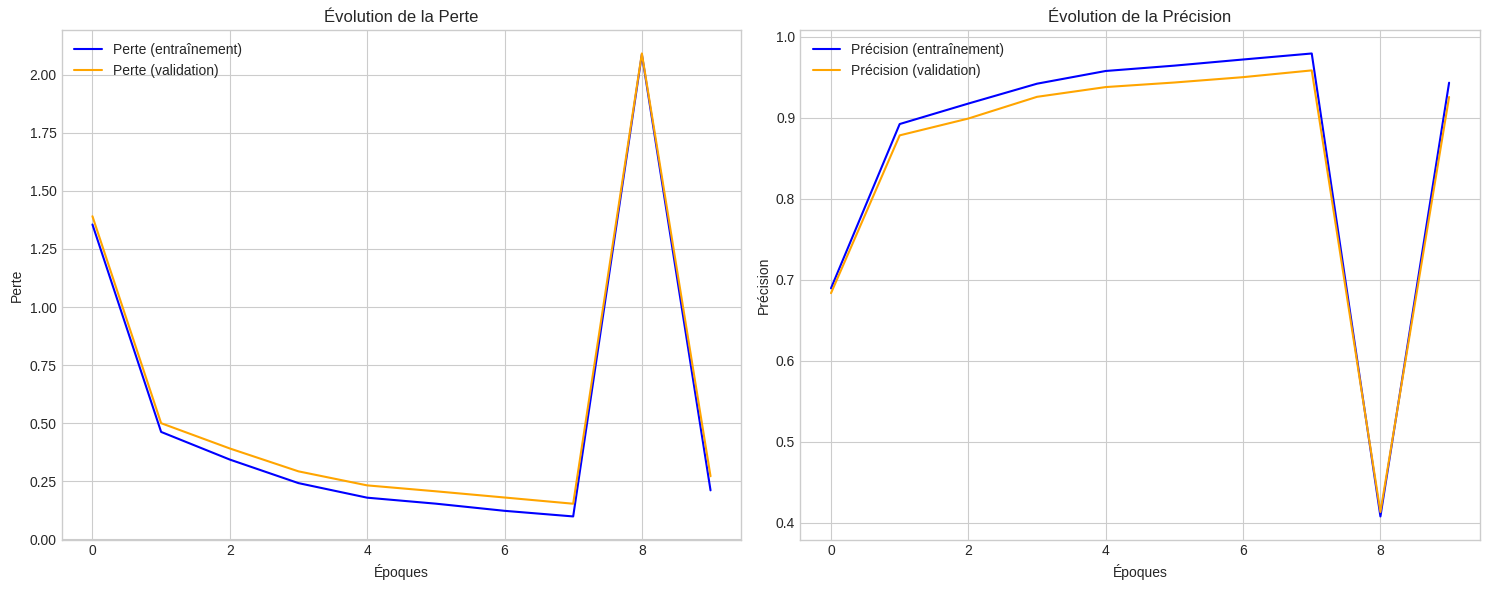

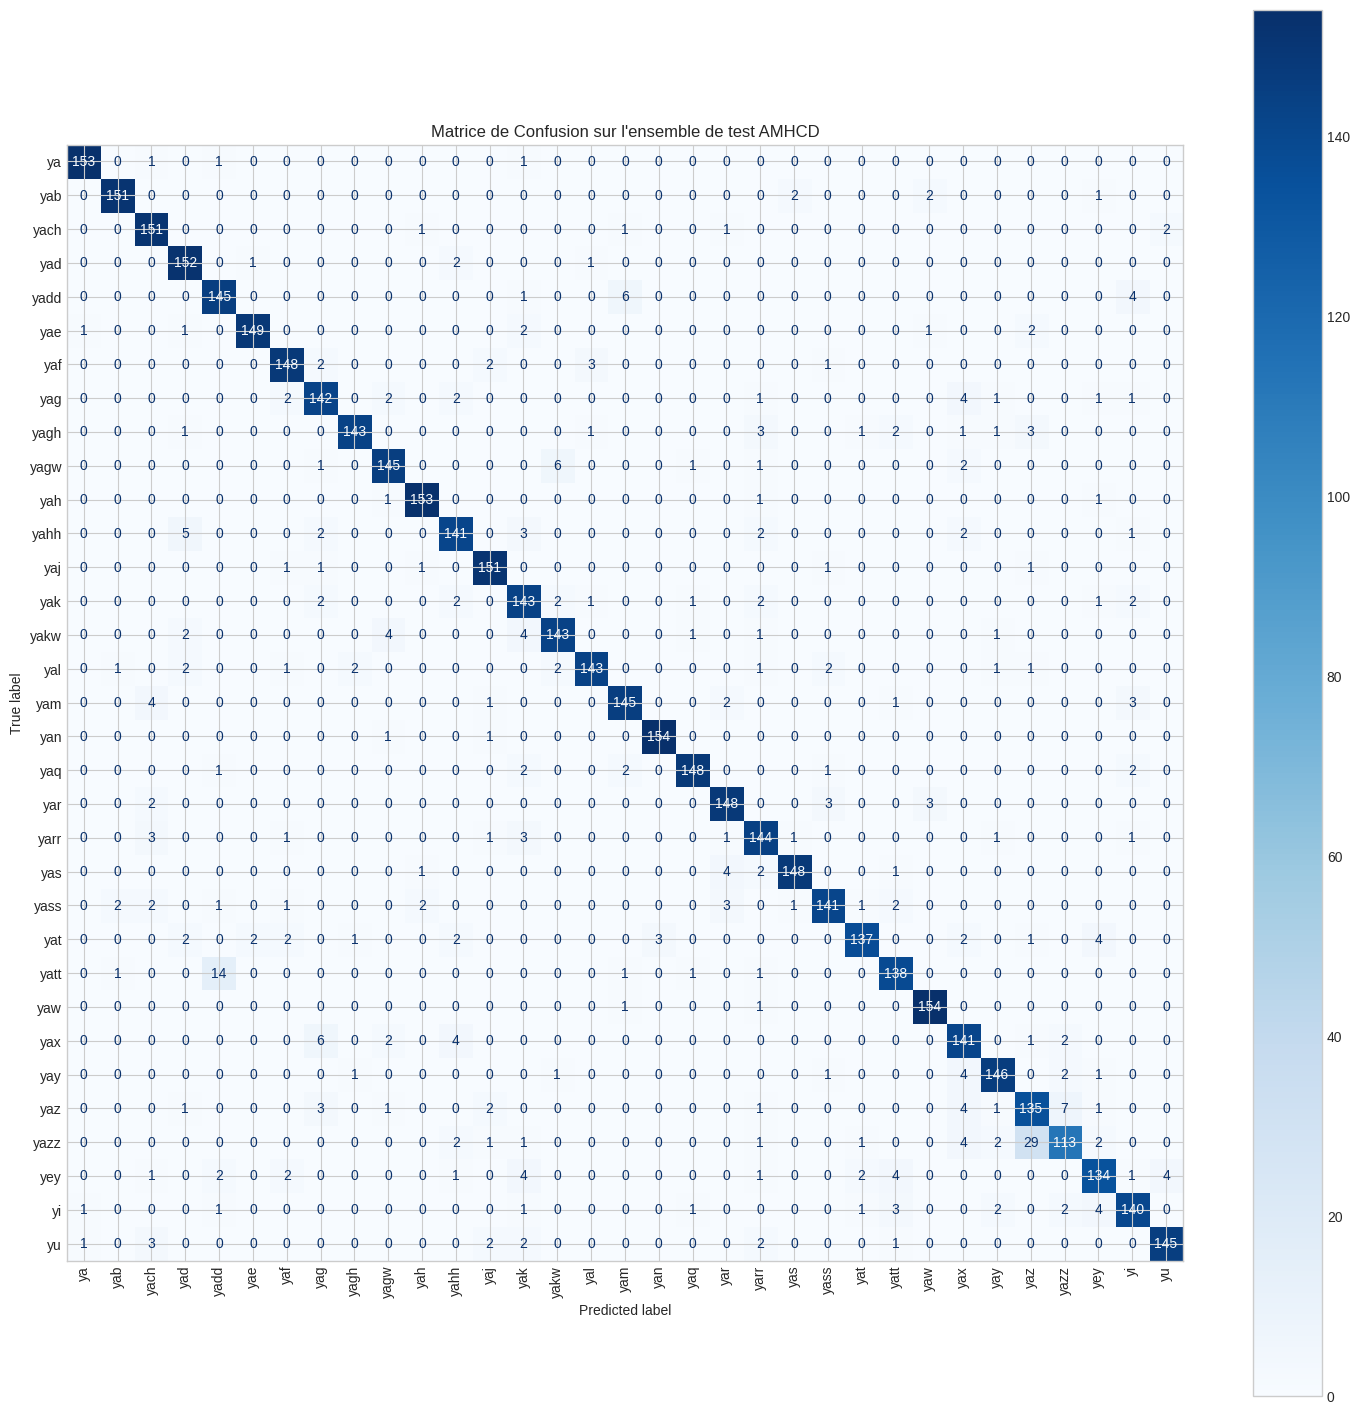

In [10]:
def plot_history(history):

    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(15, 6))


    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Perte (entraînement)', color='blue')
    plt.plot(history['val_loss'], label='Perte (validation)', color='orange')
    plt.title('Évolution de la Perte')
    plt.xlabel('Époques')
    plt.ylabel('Perte')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['accuracy'], label='Précision (entraînement)', color='blue')
    plt.plot(history['val_accuracy'], label='Précision (validation)', color='orange')
    plt.title('Évolution de la Précision')
    plt.xlabel('Époques')
    plt.ylabel('Précision')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)

y_pred_test = model.forward(x_test)
y_pred_classes = np.argmax(y_pred_test, axis=1)

cm = confusion_matrix(y_test_labels, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(18, 18))
disp.plot(ax=ax, xticks_rotation='vertical', cmap='Blues')
plt.title('Matrice de Confusion sur l\'ensemble de test AMHCD')
plt.show()


Analyse des cartes de caractéristiques pour l'image de test n°15...
-> Image réelle : 'yaf' | Prédiction du modèle : 'yaf'


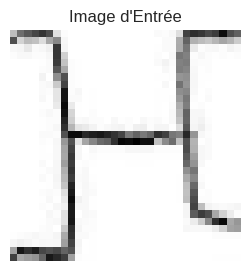

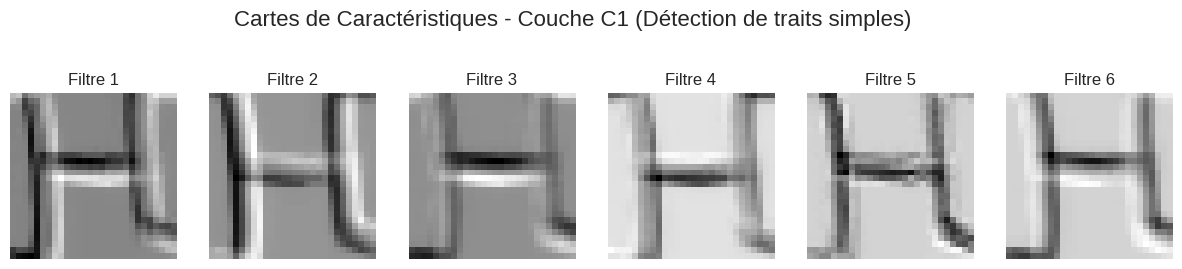

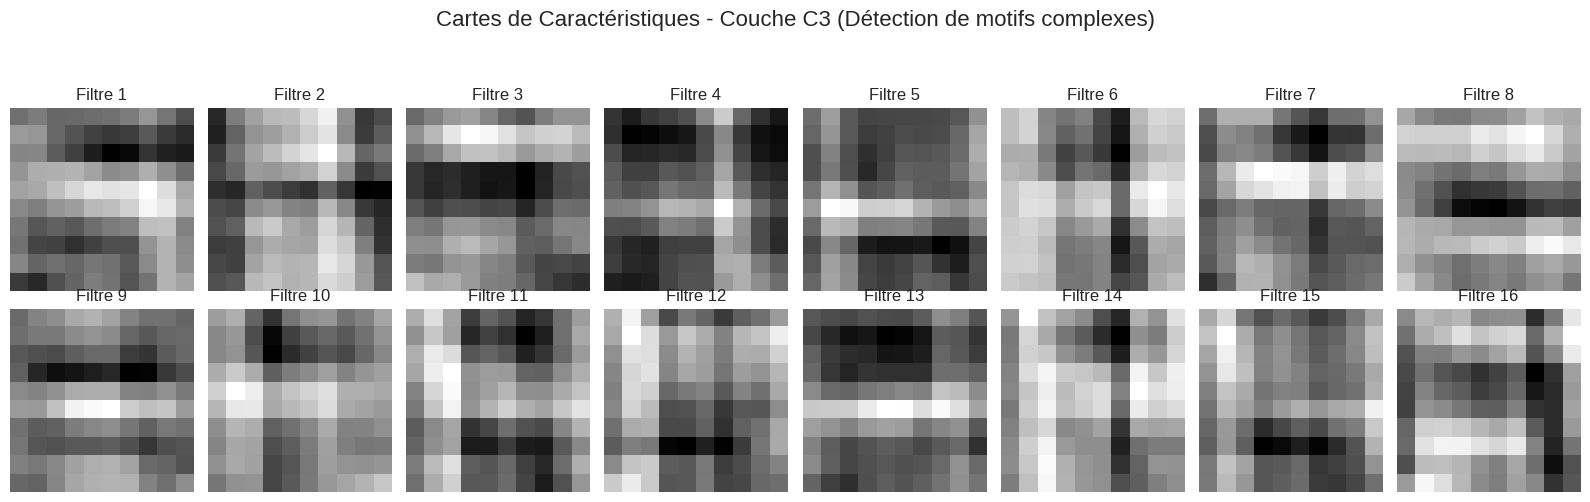

In [11]:
def visualize_feature_maps(model, image_index=0):
    print(f"\nAnalyse des cartes de caractéristiques pour l'image de test n°{image_index}...")

    img = x_test[image_index:image_index+1]
    true_label_index = y_test_labels[image_index]
    true_label_name = class_names[true_label_index]

    prediction_probs = model.forward(img)
    predicted_label_index = np.argmax(prediction_probs)
    predicted_label_name = class_names[predicted_label_index]

    print(f"-> Image réelle : '{true_label_name}' | Prédiction du modèle : '{predicted_label_name}'")

    plt.figure(figsize=(3, 3))
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title("Image d'Entrée")
    plt.axis('off')
    plt.show()

    c1_maps = model.feature_maps_c1[0]
    fig, axes = plt.subplots(1, 6, figsize=(15, 3))
    fig.suptitle('Cartes de Caractéristiques - Couche C1 (Détection de traits simples)', fontsize=16, y=1.05)
    for i, ax in enumerate(axes):
        ax.imshow(c1_maps[i], cmap='gray')
        ax.set_title(f'Filtre {i+1}')
        ax.axis('off')
    plt.show()

    c3_maps = model.feature_maps_c3[0]
    fig, axes = plt.subplots(2, 8, figsize=(16, 5))
    fig.suptitle('Cartes de Caractéristiques - Couche C3 (Détection de motifs complexes)', fontsize=16, y=1.02)
    axes = axes.flatten()
    for i in range(16):
        axes[i].imshow(c3_maps[i], cmap='gray')
        axes[i].set_title(f'Filtre {i+1}')
        axes[i].axis('off')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

visualize_feature_maps(model, image_index=15)